# Clasificador binario con ExtraTreesClassifier del tipo de violencia "atención no autorizada" y "abuso y violencia".

Se tienen dos tipos "no tuvo violencia" y "abuso y violencia". No incluye a los de la categoría "ambos" ni a los que no sufieron violencia.

Sin preprocesamiento en el dataset. Todas las columnas se tratan como continuas aunque sean categóricas.

https://www.cienciadedatos.net/documentos/py08_random_forest_python.html

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html?highlight=forest#sklearn.ensemble.RandomForestClassifier

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesClassifier.html

---

https://github.com/serengil/chefboost

https://towardsdatascience.com/chefboost-an-alternative-python-library-for-tree-based-models-f46af028a348

    @misc{serengil2021chefboost,
      author       = {Serengil, Sefik Ilkin},
      title        = {ChefBoost: A Lightweight Boosted Decision Tree Framework},
      month        = oct,
      year         = 2021,
      publisher    = {Zenodo},
      doi          = {10.5281/zenodo.5576203},
      howpublished = {https://doi.org/10.5281/zenodo.5576203}
    }

In [1]:
# Custom functions
# ==============================================================================
from funciones import CargarPandasDatasetCategoricos, BorrarColumnas, InsertarColumnaNueva

# Tratamiento de datos
# ==============================================================================
import numpy as np
import pandas as pd
import time

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns

# Preprocesado y modelado
# ==============================================================================
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.model_selection import ParameterGrid, KFold
from chefboost import Chefboost as chef
from sklearn.model_selection import train_test_split

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

In [2]:
def clasificacionAbuso(row):
    if row['P9_8'] == 1 or row['P9_8'] == 3:
        return 1
    return 0

def clasificacionAtencion(row):
    if row['P9_8'] == 2 or row['P9_8'] == 3:
        return 1
    return 0

In [3]:
def grid(param_grid, X, y, cv=5):
    resultados = {'params': [], 'f1_abuso': [], 'cm_abuso': [], 'f1_atencion': [], 'cm_atencion': []}
    importances = []
    kf = KFold(n_splits=cv, shuffle=True)
    
    for i,params in enumerate(param_grid):
        f1_abuso = []
        f1_atencion = []
        cm_abuso = []
        cm_atencion = []

        for train_index, test_index in kf.split(X):

            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]

            modelo = RandomForestClassifier(
                        n_jobs       = -1,
                        ** params
                     )

            modelo.fit(X_train, y_train)

            y_pred = modelo.predict(X_test)
            
            importances.append(modelo.feature_importances_)
            
            f1_abuso.append(f1_score(y_test['P9_8_abuso'], y_pred[:, 0]))
            f1_atencion.append(f1_score(y_test['P9_8_atencion'], y_pred[:, 1]))
            cm_abuso.append(confusion_matrix(y_test['P9_8_abuso'], y_pred[:, 0], labels=[0, 1]).ravel())
            cm_atencion.append(confusion_matrix(y_test['P9_8_atencion'], y_pred[:, 1], labels=[0, 1]).ravel())
            
        resultados['params'].append(params)
        resultados['f1_abuso'].append(max(f1_abuso))
        resultados['cm_abuso'].append(cm_abuso[f1_abuso.index(max(f1_abuso))])
        resultados['f1_atencion'].append(max(f1_atencion))
        resultados['cm_atencion'].append(cm_atencion[f1_atencion.index(max(f1_atencion))])
        
        if i%300 == 0 or i==len(param_grid):
            print(f"Modelo {i}: {params} \u2713")
    
    #hacer dataset con resultados
    resultados = pd.DataFrame(resultados)
    resultados = pd.concat([resultados, resultados['params'].apply(pd.Series)], axis=1)
    resultados = resultados.drop(columns = 'params')
    
    return resultados, importances

In [4]:
def asegurarPrimerSi(df, value='Si'):
    indice = list(df.index) #obtengo lista de indices
    a = df.P9_8.eq(value).idxmax() #obtengo el indice de la primera coincidencia en Si
    b = indice[0] #el primer indice de la lista
    indice.pop(indice.index(a)) #eliminar de 'a' la lista de indices
    indice.insert(0, a) #insertar al inicio de la lista el indice 'a'
    return df.reindex(indice) #reindizar el dataset 

## Cargar datos

In [5]:
endireh = CargarPandasDatasetCategoricos('datasets/endireh.csv')

## Preprocesamiento


Solo nos quedamos con las que sufieron violencia en general.

In [6]:
endireh = InsertarColumnaNueva(df=endireh, nombreCol='P9_8_abuso',    numeroCol=48, funcion=clasificacionAbuso)
endireh = InsertarColumnaNueva(df=endireh, nombreCol='P9_8_atencion', numeroCol=49, funcion=clasificacionAtencion)

In [7]:
endireh.loc[endireh["P9_8"]>0, "P9_8"] = 1

In [8]:
endireh.shape

(18902, 51)

Ninguno(0):	66%
Ambos(1):	34%


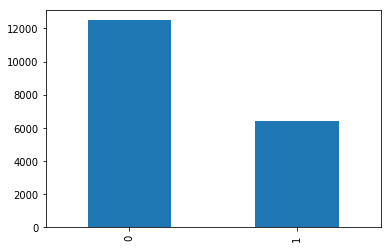

In [9]:
for i,j in zip(['Ninguno(0)', 'Ambos(1)'], endireh["P9_8"].value_counts()/endireh["P9_8"].value_counts().sum()):
    print(f'{i}:\t{round(j*100)}%')
endireh["P9_8"].value_counts().plot(kind='bar')

Al ser el análisis nacional borramos la variable _REGION_ que no pertenece a este estudio en particular y Elimino _y_ del dataset.

In [10]:
endireh.drop(columns=['REGION'], inplace=True)

Obtengo la variable objetivo y obtengo el dataset X borrando P9_8.

In [11]:
y = endireh[['P9_8_abuso', 'P9_8_atencion']].copy()
X = endireh.drop(columns=['P9_8', 'P9_8_abuso', 'P9_8_atencion'], inplace=False)

Borro 'P9_8_abuso', 'P9_8_atencion' del dataset de Chef

In [12]:
endireh.drop(columns=['P9_8_abuso', 'P9_8_atencion'], inplace=True)

In [13]:
endireh.loc[endireh["P9_8"]==0, "P9_8"] = 'No'
endireh.loc[endireh["P9_8"]==1, "P9_8"] = 'Si'

In [14]:
X_train, X_test = train_test_split(endireh, test_size=0.2, random_state=5, stratify=endireh['P9_8'])

In [15]:
X_train = asegurarPrimerSi(X_train)
X_test  = asegurarPrimerSi(X_test)

## Encontrar los mejores parámetros con _Random Forest_

In [12]:
param_grid = ParameterGrid(
                {
                 'max_features'      : ['auto', 'sqrt', 'log2'],
                 'criterion'         : ['gini', 'entropy'],
                 'warm_start'        : [True, False],
                 'bootstrap'         : [True, False],
                 'min_samples_split' : range(285, 580, 25),
                 'min_samples_leaf'  : range(150, 200, 2),
                 'random_state'      : [5],
                }
            )


In [13]:
print("Current Time is :", time.strftime("%H:%M:%S", time.localtime()))

Current Time is : 17:52:48


In [14]:
%time resultados, importances = grid(param_grid, X, y, cv=5)

Modelo 0: {'bootstrap': True, 'criterion': 'gini', 'max_features': 'auto', 'min_samples_leaf': 150, 'min_samples_split': 285, 'random_state': 5, 'warm_start': True} ✓
Modelo 300: {'bootstrap': True, 'criterion': 'gini', 'max_features': 'auto', 'min_samples_leaf': 174, 'min_samples_split': 435, 'random_state': 5, 'warm_start': True} ✓
Modelo 600: {'bootstrap': True, 'criterion': 'gini', 'max_features': 'sqrt', 'min_samples_leaf': 150, 'min_samples_split': 285, 'random_state': 5, 'warm_start': True} ✓
Modelo 900: {'bootstrap': True, 'criterion': 'gini', 'max_features': 'sqrt', 'min_samples_leaf': 174, 'min_samples_split': 435, 'random_state': 5, 'warm_start': True} ✓
Modelo 1200: {'bootstrap': True, 'criterion': 'gini', 'max_features': 'log2', 'min_samples_leaf': 150, 'min_samples_split': 285, 'random_state': 5, 'warm_start': True} ✓
Modelo 1500: {'bootstrap': True, 'criterion': 'gini', 'max_features': 'log2', 'min_samples_leaf': 174, 'min_samples_split': 435, 'random_state': 5, 'warm_st

In [15]:
print("Current Time is :", time.strftime("%H:%M:%S", time.localtime()))

Current Time is : 01:11:03


In [16]:
resultados.sort_values(by=['f1_abuso'], ascending=False).head(10)

,f1_abuso,cm_abuso,f1_atencion,cm_atencion,bootstrap,criterion,max_features,min_samples_leaf,min_samples_split,random_state,warm_start
0,0.0,"[2784, 0, 997, 0]",0.0,"[3147, 0, 634, 0]",True,gini,auto,150,285,5,True
4837,0.0,"[2796, 0, 985, 0]",0.0,"[3194, 0, 587, 0]",False,gini,log2,152,435,5,False
4807,0.0,"[2721, 0, 1060, 0]",0.0,"[3140, 0, 641, 0]",False,gini,log2,150,360,5,False
4806,0.0,"[2790, 0, 991, 0]",0.0,"[3124, 0, 657, 0]",False,gini,log2,150,360,5,True
4805,0.0,"[2734, 0, 1047, 0]",0.0,"[3125, 0, 656, 0]",False,gini,log2,150,335,5,False
4804,0.0,"[2737, 0, 1044, 0]",0.0,"[3151, 0, 630, 0]",False,gini,log2,150,335,5,True
4803,0.0,"[2770, 0, 1011, 0]",0.0,"[3129, 0, 652, 0]",False,gini,log2,150,310,5,False
4802,0.0,"[2772, 0, 1009, 0]",0.0,"[3147, 0, 634, 0]",False,gini,log2,150,310,5,True
4801,0.0,"[2828, 0, 953, 0]",0.0,"[3142, 0, 639, 0]",False,gini,log2,150,285,5,False
4800,0.0,"[2784, 0, 997, 0]",0.0,"[3128, 0, 653, 0]",False,gini,log2,150,285,5,True


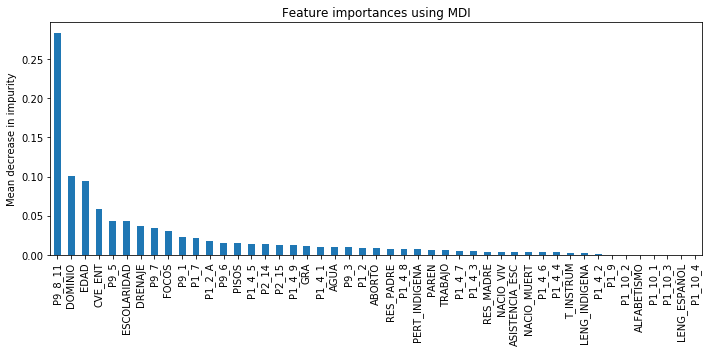

In [17]:
forest_importances = pd.Series(np.mean(importances, axis = 0), index=X.columns)
forest_importances.sort_values(ascending=False, inplace=True)

fig, ax = plt.subplots(figsize=(10,5))
#forest_importances[:15].plot.bar(yerr=std, ax=ax)
forest_importances.plot.bar(ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

### ID3

In [16]:
config = {'algorithm':'ID3', 'enableParallelism':True, 'num_cores': -1, 'max_depth': 6}
%time model = chef.fit(X_train, config = config, target_label = 'P9_8');print('\n')

[INFO]:  -1 CPU cores will be allocated in parallel running
ID3  tree is going to be built...
-------------------------
finished in  2142.8424689769745  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  100.0 % on  15121  instances
Labels:  ['Si' 'No']
Confusion matrix:  [[5130, 0], [0, 9991]]
Precision:  100.0 %, Recall:  100.0 %, F1:  100.0 %


CPU times: user 35min 35s, sys: 8 s, total: 35min 43s
Wall time: 35min 44s


In [17]:
chef.evaluate(model, X_test, target_label='P9_8', task="test")

-------------------------
Evaluate  test set
-------------------------
Accuracy:  56.5987833906374 % on  3781  instances
Labels:  ['Si' 'No']
Confusion matrix:  [[520, 878], [763, 1620]]
Precision:  37.196 %, Recall:  40.53 %, F1:  38.7915 %


### C4.5

In [18]:
config = {'algorithm':'C4.5', 'enableParallelism':True, 'num_cores': -1, 'max_depth': 6}
%time model = chef.fit(X_train, config = config, target_label = 'P9_8');print('\n')

[INFO]:  -1 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...
-------------------------
finished in  2242.9967954158783  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  100.0 % on  15121  instances
Labels:  ['Si' 'No']
Confusion matrix:  [[5130, 0], [0, 9991]]
Precision:  100.0 %, Recall:  100.0 %, F1:  100.0 %


CPU times: user 37min 15s, sys: 8.81 s, total: 37min 23s
Wall time: 37min 24s


In [19]:
chef.evaluate(model, X_test, target_label='P9_8', task="test")

-------------------------
Evaluate  test set
-------------------------
Accuracy:  55.64665432425284 % on  3781  instances
Labels:  ['Si' 'No']
Confusion matrix:  [[510, 904], [773, 1594]]
Precision:  36.0679 %, Recall:  39.7506 %, F1:  37.8198 %


### CHAID

In [20]:
config = {'algorithm':'CHAID', 'enableParallelism':True, 'num_cores': -1, 'max_depth': 6}
%time model = chef.fit(X_train, config = config, target_label = 'P9_8');print('\n')

[INFO]:  -1 CPU cores will be allocated in parallel running
CHAID  tree is going to be built...
-------------------------
finished in  2992.2290210723877  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  100.0 % on  15121  instances
Labels:  ['Si' 'No']
Confusion matrix:  [[5130, 0], [0, 9991]]
Precision:  100.0 %, Recall:  100.0 %, F1:  100.0 %


CPU times: user 49min 43s, sys: 8.32 s, total: 49min 52s
Wall time: 49min 53s


In [21]:
chef.evaluate(model, X_test, target_label='P9_8', task="test")

-------------------------
Evaluate  test set
-------------------------
Accuracy:  55.40862205765671 % on  3781  instances
Labels:  ['Si' 'No']
Confusion matrix:  [[460, 863], [823, 1635]]
Precision:  34.7695 %, Recall:  35.8535 %, F1:  35.3032 %


### CART

In [22]:
config = {'algorithm':'CART', 'enableParallelism':True, 'num_cores': -1, 'max_depth': 6}
%time model = chef.fit(X_train, config = config, target_label = 'P9_8');print('\n')

[INFO]:  -1 CPU cores will be allocated in parallel running
CART  tree is going to be built...
-------------------------
finished in  1856.0662682056427  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  100.0 % on  15121  instances
Labels:  ['Si' 'No']
Confusion matrix:  [[5130, 0], [0, 9991]]
Precision:  100.0 %, Recall:  100.0 %, F1:  100.0 %


CPU times: user 30min 49s, sys: 7.57 s, total: 30min 56s
Wall time: 30min 57s


In [23]:
chef.evaluate(model, X_test, target_label='P9_8', task="test")

-------------------------
Evaluate  test set
-------------------------
Accuracy:  56.01692673895795 % on  3781  instances
Labels:  ['Si' 'No']
Confusion matrix:  [[499, 879], [784, 1619]]
Precision:  36.2119 %, Recall:  38.8932 %, F1:  37.5047 %


### enableGBM

In [24]:
config = {'enableGBM': True, 'enableParallelism':True, 'num_cores': -1, 'max_depth': 6}
%time model = chef.fit(X_train, config = config, target_label = 'P9_8');print('\n')

Boosting:   0%|          | 0/10 [00:00<?, ?it/s]

[INFO]:  -1 CPU cores will be allocated in parallel running
Gradient Boosting Machines...
Regression  tree is going to be built...
gradient boosting for classification


Epoch 10. Accuracy: 91. Process: : 100%|██████████| 10/10 [5:30:20<00:00, 1982.05s/it]


The best accuracy got in  8  epoch with the score  92.20950995304544
-------------------------
finished in  19820.544476509094  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  91.8854573110244 % on  15121  instances
Labels:  ['Si' 'No']
Confusion matrix:  [[4227, 324], [903, 9667]]
Precision:  92.8807 %, Recall:  82.3977 %, F1:  87.3257 %


CPU times: user 5h 29min 3s, sys: 1min 12s, total: 5h 30min 15s
Wall time: 5h 30min 22s


In [25]:
chef.evaluate(model, X_test, target_label='P9_8', task="test")

-------------------------
Evaluate  test set
-------------------------
Accuracy:  58.582385612271885 % on  3781  instances
Labels:  ['Si' 'No']
Confusion matrix:  [[395, 678], [888, 1820]]
Precision:  36.8127 %, Recall:  30.7872 %, F1:  33.5314 %


### Feature importance

In [26]:
fi = chef.feature_importance("outputs/rules/rules-for-No-round-0.py").set_index('feature')
for i in range(1, 10):
    fi = fi.join(chef.feature_importance(f"outputs/rules/rules-for-No-round-{i}.py").set_index('feature'), rsuffix=i)
    #fi = pd.merge(fi, chef.feature_importance(f"outputs/rules/rule_{i}.py").set_index('feature'), left_index=True, right_index=True)
    #fi  = pd.concat([fi, chef.feature_importance(f"outputs/rules/rule_{i}.py").set_index('feature')], axis=1)

Decision rule:  outputs/rules/rules-for-No-round-0.py
Decision rule:  outputs/rules/rules-for-No-round-1.py
Decision rule:  outputs/rules/rules-for-No-round-2.py
Decision rule:  outputs/rules/rules-for-No-round-3.py
Decision rule:  outputs/rules/rules-for-No-round-4.py
Decision rule:  outputs/rules/rules-for-No-round-5.py
Decision rule:  outputs/rules/rules-for-No-round-6.py
Decision rule:  outputs/rules/rules-for-No-round-7.py
Decision rule:  outputs/rules/rules-for-No-round-8.py
Decision rule:  outputs/rules/rules-for-No-round-9.py


In [28]:
fi.insert(10, "std", fi.std(axis=1))
fi.insert(11, "mean", fi.mean(axis=1))
fi.insert(12, "min", fi.min(axis=1))
fi.insert(13, "max", fi.max(axis=1))

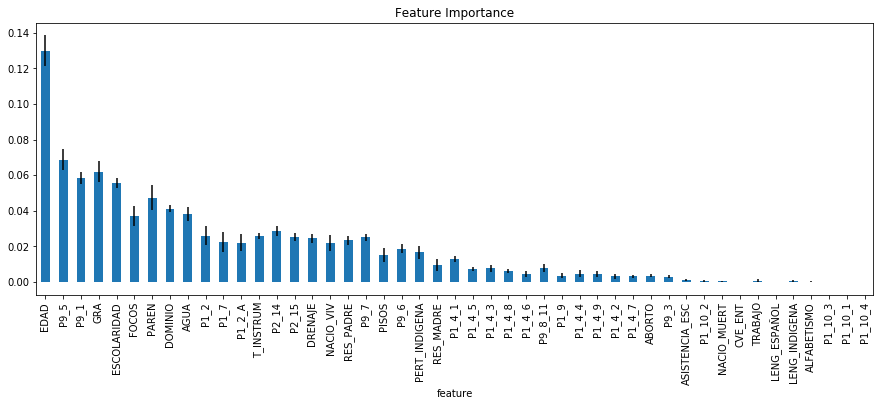

In [30]:
fi['mean'].plot.bar(title="Feature Importance", figsize=(15,5), yerr=fi['std'])

### enableRandomForest 5

In [32]:
config = {'enableRandomForest':True, 'num_of_trees':5, 'algorithm':'CART', 'enableParallelism':True, 'num_cores': 8, 'max_depth': 6}
%time model1 = chef.fit(X_train, config = config, target_label = 'P9_8');print('\n')

Sub decision tree 5 is processing: 100%|██████████| 5/5 [00:00<00:00, 216.05it/s]

[INFO]:  8 CPU cores will be allocated in parallel running
CART  tree is going to be built...



100%|██████████| 5/5 [03:39<00:00, 43.88s/it] 


-------------------------
finished in  219.55368304252625  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  72.47536538588717 % on  15121  instances
Labels:  ['Si' 'No']
Confusion matrix:  [[2542, 1574], [2588, 8417]]
Precision:  61.759 %, Recall:  49.5517 %, F1:  54.986 %


CPU times: user 2.16 s, sys: 128 ms, total: 2.29 s
Wall time: 3min 41s


In [33]:
chef.evaluate(model1, X_test, target_label='P9_8', task="test")

-------------------------
Evaluate  test set
-------------------------
Accuracy:  59.2964824120603 % on  3781  instances
Labels:  ['Si' 'No']
Confusion matrix:  [[361, 617], [922, 1881]]
Precision:  36.9121 %, Recall:  28.1372 %, F1:  31.9328 %


### enableRandomForest 100

In [34]:
config = {'enableRandomForest':True, 'num_of_trees':100, 'algorithm':'CART', 'enableParallelism':True, 'num_cores': 8, 'max_depth': 6}
%time model1 = chef.fit(X_train, config = config, target_label = 'P9_8');print('\n')

Sub decision tree 100 is processing: 100%|██████████| 100/100 [00:00<00:00, 764.50it/s]

[INFO]:  8 CPU cores will be allocated in parallel running
CART  tree is going to be built...



100%|██████████| 100/100 [02:10<00:00,  1.31s/it]


-------------------------
finished in  130.84362721443176  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  66.15303220686462 % on  15121  instances
Labels:  ['Si' 'No']
Confusion matrix:  [[122, 110], [5008, 9881]]
Precision:  52.5862 %, Recall:  2.3782 %, F1:  4.5506 %


CPU times: user 4.41 s, sys: 136 ms, total: 4.54 s
Wall time: 2min 14s


In [35]:
chef.evaluate(model1, X_test, target_label='P9_8', task="test")

-------------------------
Evaluate  test set
-------------------------
Accuracy:  65.77624966939963 % on  3781  instances
Labels:  ['Si' 'No']
Confusion matrix:  [[19, 30], [1264, 2468]]
Precision:  38.7755 %, Recall:  1.4809 %, F1:  2.8528 %


### Feature importance

In [36]:
fi1 = chef.feature_importance("outputs/rules/rule_0.py").set_index('feature')
for i in range(1, 100):
    fi1 = fi1.join(chef.feature_importance(f"outputs/rules/rule_{i}.py").set_index('feature'), rsuffix=i)
    #fi = pd.merge(fi, chef.feature_importance(f"outputs/rules/rule_{i}.py").set_index('feature'), left_index=True, right_index=True)
    #fi  = pd.concat([fi, chef.feature_importance(f"outputs/rules/rule_{i}.py").set_index('feature')], axis=1)

Decision rule:  outputs/rules/rule_0.py
Decision rule:  outputs/rules/rule_1.py
Decision rule:  outputs/rules/rule_2.py
Decision rule:  outputs/rules/rule_3.py
Decision rule:  outputs/rules/rule_4.py
Decision rule:  outputs/rules/rule_5.py
Decision rule:  outputs/rules/rule_6.py
Decision rule:  outputs/rules/rule_7.py
Decision rule:  outputs/rules/rule_8.py
Decision rule:  outputs/rules/rule_9.py
Decision rule:  outputs/rules/rule_10.py
Decision rule:  outputs/rules/rule_11.py
Decision rule:  outputs/rules/rule_12.py
Decision rule:  outputs/rules/rule_13.py
Decision rule:  outputs/rules/rule_14.py
Decision rule:  outputs/rules/rule_15.py
Decision rule:  outputs/rules/rule_16.py
Decision rule:  outputs/rules/rule_17.py
Decision rule:  outputs/rules/rule_18.py
Decision rule:  outputs/rules/rule_19.py
Decision rule:  outputs/rules/rule_20.py
Decision rule:  outputs/rules/rule_21.py
Decision rule:  outputs/rules/rule_22.py
Decision rule:  outputs/rules/rule_23.py
Decision rule:  outputs/ru

In [38]:
fi1.insert(100, "std", fi1.std(axis=1))
fi1.insert(101, "mean", fi1.mean(axis=1))
fi1.insert(102, "min", fi1.min(axis=1))
fi1.insert(103, "max", fi1.max(axis=1))

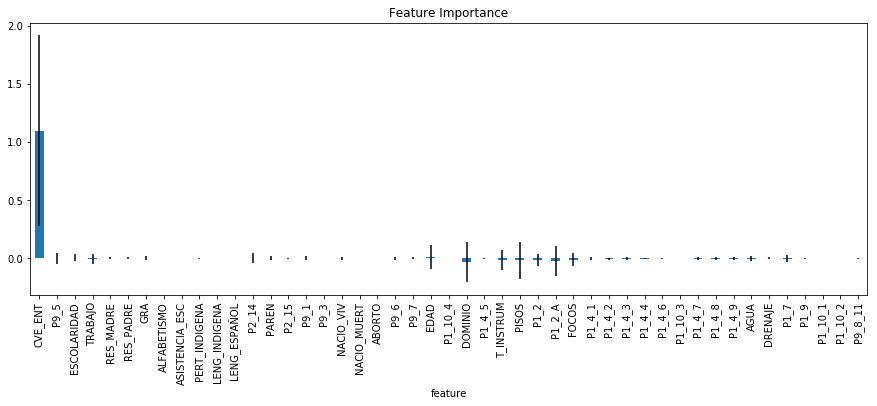

In [40]:
fi1['mean'].plot.bar(title="Feature Importance", figsize=(15,5), yerr=fi1['std'])

### CART

In [41]:
config = {'algorithm':'CART', 'enableParallelism':True, 'num_cores': -1, 'max_depth': 6}
%time model = chef.fit(X_train, config = config, target_label = 'P9_8');print('\n')

[INFO]:  -1 CPU cores will be allocated in parallel running
CART  tree is going to be built...
-------------------------
finished in  1883.4506814479828  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  100.0 % on  15121  instances
Labels:  ['Si' 'No']
Confusion matrix:  [[5130, 0], [0, 9991]]
Precision:  100.0 %, Recall:  100.0 %, F1:  100.0 %


CPU times: user 31min 16s, sys: 7.67 s, total: 31min 24s
Wall time: 31min 24s


In [42]:
chef.evaluate(model, X_test, target_label='P9_8', task="test")

-------------------------
Evaluate  test set
-------------------------
Accuracy:  56.01692673895795 % on  3781  instances
Labels:  ['Si' 'No']
Confusion matrix:  [[499, 879], [784, 1619]]
Precision:  36.2119 %, Recall:  38.8932 %, F1:  37.5047 %


### Feature importance

Decision rule:  outputs/rules/rules.py


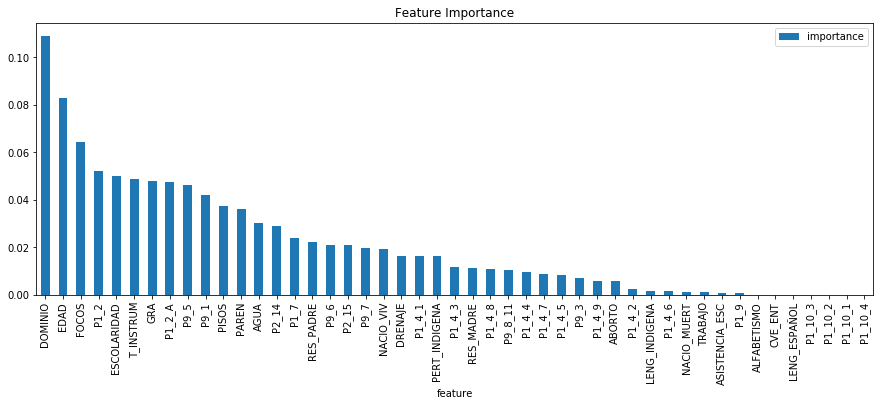

In [43]:
fi = chef.feature_importance("outputs/rules/rules.py")
fi.set_index('feature').plot.bar(title="Feature Importance", figsize=(15,5))